# Model and Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Training Parameters:
lr = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 128
test_batch_size = 100

Train_Flag = False

In [3]:
# Preparing Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])


dataset_train = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=test_batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
print('==> Building model..')
model = torchvision.models.vgg16_bn(pretrained=False).to(device)
model.classifier = torch.nn.Linear(in_features=25088, out_features=10)
model = model.to(device)


==> Building model..


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



In [6]:


# Training
def train(model, epoch, trainloader, optimizer, criterion, verbose = True):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm (enumerate(trainloader), total = len (trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        torch.cuda.empty_cache()
        if verbose:
            print (f"epoch:{epoch}, {batch_idx}/{len(trainloader)}", 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(model, epoch, testloader, criterion, verbose = True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm (enumerate(testloader), total = len (testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if verbose:
                print (f"epoch:{epoch}, {batch_idx}/{len(testloader)}", 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

                

    # Save checkpoint.
    acc = 100.*correct/total
    torch.cuda.empty_cache()
    return acc




In [7]:
if Train_Flag:
    best_acc = 0  # best test accuracy
    for epoch in tqdm (range(200)):
        train(model, epoch, train_loader, optimizer, criterion)
        acc = test(model, epoch, test_loader, criterion)
        scheduler.step()
        
        if acc > best_acc:
            print('Saving..')
            torch.save(model.state_dict(), 'ckpt.pth')
            best_acc = acc

else:
    model.load_state_dict (torch.load("ckpt.pth"))
    epoch = 0
    acc = test (model, epoch, test_loader, criterion, verbose = False)
    print ("loaded pretrained model with", acc, "% accuracy on test images")


loaded pretrained model with 94.08 % accuracy on test images


In [8]:
def filter_mask(mask, topp = 0.2):
    mask_torch = mask
    if isinstance (mask , np.ndarray):
        mask_torch = torch.tensor(mask)
    mask_linear = mask_torch.reshape(-1)
    _, mask_sortedargs = mask_linear.sort()
    mask_ones = torch.ones(len(mask_linear))
    mask_ones[:int(len(mask_linear) * (1-topp))] = 0.0
    mask_linear = mask_ones[mask_sortedargs.argsort()]
    
    return mask_linear.reshape(mask.shape)

class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, masks):
        self.data = data
        self.labels = labels
        self.masks = masks
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        filtered_mask = filter_mask (self.masks[idx])
        img = img * filtered_mask

        return img, label

def generate_masked_dataset(dataset, mask_generator, max_iters = 100):
    masks = []
    images = []
    labels = []
    
    if max_iters is not None:
        max_iters = min(max_iters, len(dataset))
    else:
        max_iters = len(dataset)
    
    dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle = True)
    for i, (x,y) in tqdm (enumerate (dataloader), total = max_iters):
        x, y = deepcopy (x[0]), deepcopy (y[0])
        images.append(x)
        labels.append(y)    
        mask = mask_generator(x, y)
        masks.append(mask)
        if i > max_iters:
            break
    return MaskedDataset(images, labels, masks)


# lime

In [9]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
model_lime = deepcopy (model)

In [10]:
def batch_predict(images):
    model_lime.eval()
    batch = torch.stack(tuple(torch.tensor (i).permute([2,0,1]) for i in images), dim=0)

    if (batch.dtype == torch.float64):
        batch = batch.to(torch.float32)  

    if (batch.dtype == torch.uint8):
        batch = batch.float()/255     

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_lime.to(device)
    batch = batch.to(device)
    
    logits = model_lime(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [11]:
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=1,
                                        max_dist=5, ratio=0.8,
                                        random_seed=100)

def limeExplanation(img, label):
    # img shape: [C, H, W]
    img = img.permute ([1,2,0]).to(torch.float64).numpy()
    explainer = lime_image.LimeImageExplainer(verbose = False)
    explanation = explainer.explain_instance(img, 
                                             batch_predict, # classification function
                                             top_labels=3, 
                                             hide_color=0, 
                                             num_samples=100, segmentation_fn=segmentation_fn) # number of images that will be sent to classification function
    
    mask_on_img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features = 3, hide_rest=False)
    img_boundry2 = mark_boundaries(mask_on_img, mask)
    return mask, img_boundry2, mask_on_img

def plotrow(ax, idx, img, mask, img_boundry2, mask_on_img):
    if isinstance(img, torch.Tensor):
        img = img.permute ([1,2,0]).numpy()

    ax[idx,0].imshow(img)
    ax[idx,0].set_title("Input")
    ax[idx,0].axis('off')

    ax[idx,1].imshow(mask)
    ax[idx,1].set_title("mask")
    ax[idx,1].axis('off')

    ax[idx,2].imshow(mask_on_img)
    ax[idx,2].set_title("mask on iamge")
    ax[idx,2].axis('off')

    ax[idx,3].imshow(img_boundry2)
    ax[idx,3].set_title("mask boundaries")
    ax[idx,3].axis('off')

In [ ]:
imgs,labels = next (iter (test_loader))


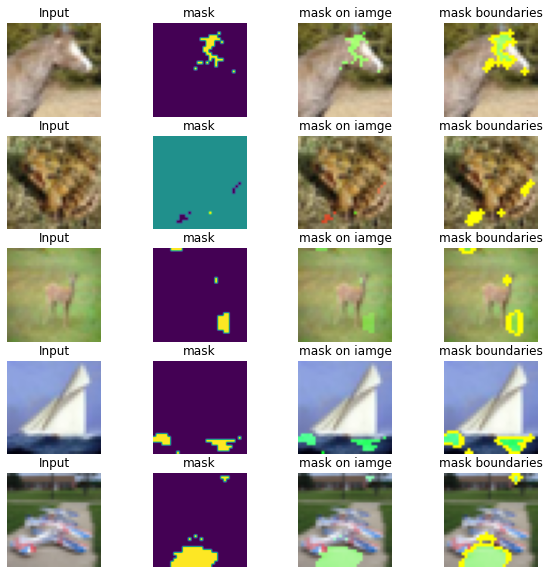

In [12]:

fig, ax = plt.subplots(5,4, figsize=(10, 10))
for i in range(5):
    img = imgs[i]
    label = labels[i].item()
    mask, img_boundry2, mask_on_img = limeExplanation(img, label)
    plotrow(ax, i, img, mask, img_boundry2, mask_on_img)

plt.show()

In [13]:
dataset_test_lime = generate_masked_dataset(dataset_test, mask_generator = lambda x, y : limeExplanation(x,y)[0])
test_loader_lime = torch.utils.data.DataLoader(dataset_test_lime, test_batch_size, shuffle = True)

In [14]:

test(model, epoch, test_loader_lime, criterion, verbose = True)

epoch:0, 0/2 Loss: 5.712 | Acc: 12.000% (12/100)
epoch:0, 1/2 Loss: 5.609 | Acc: 11.765% (12/102)



11.764705882352942

# Shapley (GradientExplainer)

In [15]:
model_shapley = deepcopy (model)

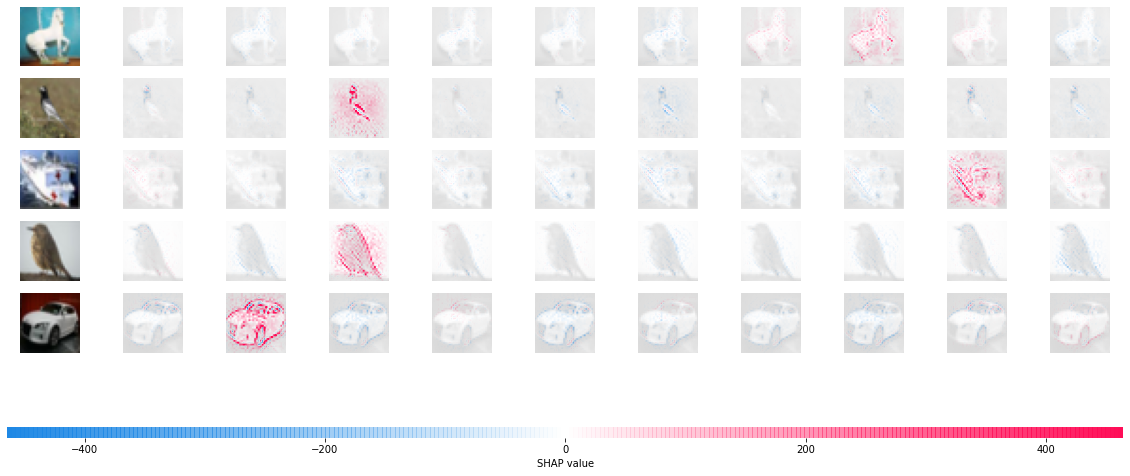

In [19]:
import shap
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)
model_shapley.eval()

test_batch_size = len(images)

background = images[:test_batch_size-5]
test_images = images[test_batch_size-5:]

e = shap.DeepExplainer(model_shapley, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [17]:
def shapExplanation(x,y):
    shap_values = e.shap_values(x[None].to(device))
    torch.cuda.empty_cache()
    return torch.tensor(shap_values[y][0])

In [18]:
dataset_test_shap = generate_masked_dataset(dataset_test, shapExplanation, max_iters = 10)
test_loader_shap = torch.utils.data.DataLoader(dataset_test_shap, test_batch_size, shuffle = True)

KeyboardInterrupt: 

In [ ]:

test(model, epoch, test_loader_shap, criterion, verbose = True)

In [ ]:
def normalize_and_permute(x):
    no = (x - x.min()) / (x.max() - x.min())
    if len(no.shape) == 3:
        no = no.permute([1,2,0])
    return no

plt.imshow (normalize_and_permute(dataset_test_shap.data[2]), cmap = "gray")
plt.show()
plt.imshow (normalize_and_permute(dataset_test_shap.masks[2]), cmap = "gray")
plt.show()

# lrp

In [54]:
import lrp
from visualization import project, clip_quantile, heatmap_grid, grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive # PatternNet patterns


In [55]:
model_lrp = lrp.convert_vgg(deepcopy (model)).to(device)

In [56]:
patterns = fit_patternnet_positive(model_lrp, train_loader, device=device)

 12%|█████████▌                                                                       | 46/391 [00:08<01:06,  5.21it/s]


KeyboardInterrupt: 

In [57]:

batch = next(iter(test_loader))
x, y = batch
x = x[:6]
y = y[:6]

x = x.to(device)
x = x.requires_grad_(True)

batch_to_append = batch[0][:31].clone()
batch_to_append = batch_to_append
batch_to_append = batch_to_append.requires_grad_(True)

In [58]:
def LRPMask(x, model_lrp, rule, patterns):
    x = x.to(device)
    x = x.detach()
    x.requires_grad_(True)
    
    # Forward pass
    y_hat_lrp = model_lrp.forward(x, explain=True, rule=rule, pattern=patterns)

    # Choose argmax
    y_hat_lrp = y_hat_lrp[torch.arange(x.shape[0]), y_hat_lrp.max(1)[1]]
    y_hat_lrp = y_hat_lrp.sum()

    # Backward pass (compute explanation)
    y_hat_lrp.backward()
    attr = x.grad    
    return attr

def compute_and_plot_explanation(x, model_lrp, rule, ax_, patterns=None, plt_fn=heatmap_grid): 
    
    attr = LRPMask(x, model_lrp, rule, patterns)

    # Plot
    attr = plt_fn(attr)

    ax_.imshow(attr)
    ax_.set_title(rule)
    ax_.axis('off')
# PatternNet is typically handled a bit different, when visualized.
def signal_fn(X):
    if X.shape[1] in [1, 3]: X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    X = clip_quantile(X)
    X = project(X)
    X = grid(X)
    return X

def lrpExplanation(x, y):
    return LRPMask(torch.cat ([x[None],batch_to_append]), model_lrp, rule = 'alpha1beta0', patterns = None)[0].cpu()

Plotting


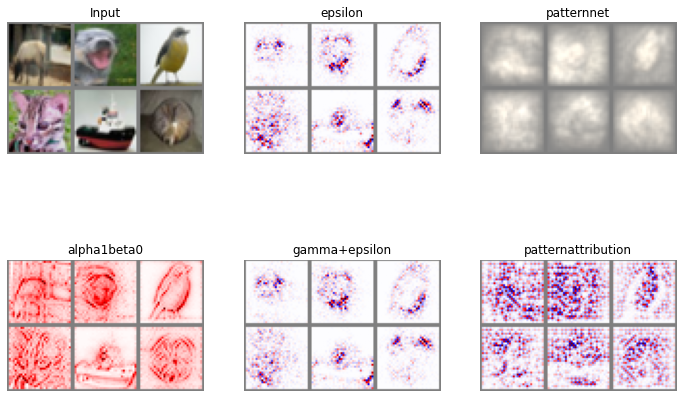

In [59]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   (1, 0)), 
        ('epsilon',             None,       heatmap_grid,   (0, 1)), 
        ('gamma+epsilon',       None,       heatmap_grid,   (1, 1)), 
        ('patternnet',          patterns,   signal_fn,      (0, 2)),
        ('patternattribution',  patterns,   heatmap_grid,   (1, 2)),
    ]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0, 0].imshow(input_to_plot)
ax[0, 0].set_title("Input")
ax[0, 0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, (p, q) ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p, q], patterns=pattern, plt_fn=fn)



In [60]:
dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters=100)

In [61]:
test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
test(model, epoch, test_loader_lrp, criterion, verbose = True)

epoch:8, 0/2 Loss: 4.596 | Acc: 30.000% (30/100)
epoch:8, 1/2 Loss: 7.156 | Acc: 29.412% (30/102)



29.41176470588235

In [62]:
# removing augmentations from train dataset

dataset_train_no_transform = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transform_test)


Files already downloaded and verified


In [64]:
dataset_train_lrp = generate_masked_dataset(dataset_train_no_transform, lrpExplanation, max_iters=1000)
train_loader_lrp = torch.utils.data.DataLoader(dataset_train_lrp, test_batch_size, shuffle = True)
test(model, epoch, train_loader_lrp, criterion, verbose = True)

epoch:8, 0/11 Loss: 5.287 | Acc: 24.000% (24/100)
epoch:8, 1/11 Loss: 5.019 | Acc: 27.500% (55/200)
epoch:8, 2/11 Loss: 5.180 | Acc: 23.667% (71/300)
epoch:8, 3/11 Loss: 5.087 | Acc: 24.250% (97/400)
epoch:8, 4/11 Loss: 5.099 | Acc: 24.200% (121/500)
epoch:8, 5/11 Loss: 5.119 | Acc: 23.333% (140/600)
epoch:8, 6/11 Loss: 5.229 | Acc: 22.429% (157/700)
epoch:8, 7/11 Loss: 5.197 | Acc: 22.875% (183/800)
epoch:8, 8/11 Loss: 5.180 | Acc: 23.333% (210/900)
epoch:8, 9/11 Loss: 5.199 | Acc: 23.000% (230/1000)
epoch:8, 10/11 Loss: 5.354 | Acc: 22.954% (230/1002)



22.954091816367267

In [65]:
class MixedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2, p = 0.02):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.p = p
        
    def update_indices(self):
        self.indices = np.random.choice(len(self.dataset1), int (len(self.dataset1) * self.p))
                
    def __len__(self):
        return len(self.indices) + len (self.dataset2)

    def __getitem__(self, idx):
        if idx < len (self.dataset2):
#             print ("dataset2")
            return self.dataset2.__getitem__(idx)
        else:
#             print ("dataset1")
            new_idx = idx - len(self.dataset2)
            img, label = self.dataset1.__getitem__(new_idx)
            return img, torch.tensor(label)
        

In [66]:
mixedDataset = MixedDataset(dataset_train , dataset_train_lrp)
mixedDataset.update_indices()
mixed_loader = torch.utils.data.DataLoader (mixedDataset, batch_size, shuffle = True)

In [67]:
from copy import deepcopy
with torch.no_grad():
    model_retrained = deepcopy(model)

optimizer_retrain = optim.SGD(model_retrained.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

In [68]:
acc1 = test(model_retrained, epoch, test_loader, criterion, verbose = False)
acc2 = test(model_retrained, epoch, train_loader_lrp, criterion, verbose = False)
acc3 = test(model_retrained, epoch, test_loader_lrp, criterion, verbose = False)
print (f"acc1:{acc1},", f"acc2:{acc2},",  f"acc3:{acc3},")


acc1:94.08, acc2:22.954091816367267, acc3:29.41176470588235,


In [69]:
best_acc = 0  # best test accuracy
for epoch in tqdm (range(20)):
    mixedDataset.update_indices()
    
    train(model_retrained, epoch, mixed_loader, optimizer_retrain, criterion)
    
    model_lrp = lrp.convert_vgg(deepcopy (model_retrained)).to(device)
    
    
    dataset_train_lrp = generate_masked_dataset(dataset_train_no_transform, lrpExplanation, max_iters=1000)
    mixedDataset = MixedDataset(dataset_train , dataset_train_lrp)
    mixedDataset.update_indices()
    mixed_loader = torch.utils.data.DataLoader (mixedDataset, batch_size, shuffle = True)
    
    dataset_test_lrp = generate_masked_dataset(dataset_test, lrpExplanation, max_iters=100)
    test_loader_lrp = torch.utils.data.DataLoader(dataset_test_lrp, test_batch_size, shuffle = True)
    
    acc1 = test(model_retrained, epoch, test_loader, criterion, verbose = False)
    acc2 = test(model_retrained, epoch, train_loader_lrp, criterion, verbose = False)
    acc3 = test(model_retrained, epoch, test_loader_lrp, criterion, verbose = False)
    print (f"acc1: {acc1} | ", f"acc2: {acc2} | ",  f"acc3: {acc3},")

#     if acc > best_acc:
#         print('Saving..')
#         torch.save(model.state_dict(), 'ckpt.pth')
#         best_acc = acc


Epoch: 0


epoch:0, 0/16 Loss: 0.929 | Acc: 83.594% (107/128)
epoch:0, 1/16 Loss: 1.033 | Acc: 79.688% (204/256)
epoch:0, 2/16 Loss: 1.150 | Acc: 78.646% (302/384)
epoch:0, 3/16 Loss: 1.187 | Acc: 77.930% (399/512)
epoch:0, 4/16 Loss: 1.178 | Acc: 77.969% (499/640)
epoch:0, 5/16 Loss: 1.239 | Acc: 77.474% (595/768)
epoch:0, 6/16 Loss: 1.217 | Acc: 78.125% (700/896)
epoch:0, 7/16 Loss: 1.249 | Acc: 77.832% (797/1024)
epoch:0, 8/16 Loss: 1.271 | Acc: 77.691% (895/1152)
epoch:0, 9/16 Loss: 1.238 | Acc: 78.281% (1002/1280)
epoch:0, 10/16 Loss: 1.232 | Acc: 78.480% (1105/1408)
epoch:0, 11/16 Loss: 1.158 | Acc: 79.557% (1222/1536)
epoch:0, 12/16 Loss: 1.166 | Acc: 79.688% (1326/1664)
epoch:0, 13/16 Loss: 1.154 | Acc: 79.855% (1431/1792)
epoch:0, 14/16 Loss: 1.139 | Acc: 80.156% (1539/1920)
epoch:0, 15/16 Loss: 1.147 | Acc: 79.920% (1600/2002)




acc1: 90.72 |  acc2: 71.45708582834331 |  acc3: 38.23529411764706,

Epoch: 1


epoch:1, 0/16 Loss: 2.443 | Acc: 63.281% (81/128)
epoch:1, 1/16 Loss: 2.375 | Acc: 66.797% (171/256)
epoch:1, 2/16 Loss: 2.508 | Acc: 65.104% (250/384)
epoch:1, 3/16 Loss: 2.332 | Acc: 67.773% (347/512)
epoch:1, 4/16 Loss: 2.292 | Acc: 67.188% (430/640)
epoch:1, 5/16 Loss: 2.182 | Acc: 68.229% (524/768)
epoch:1, 6/16 Loss: 2.097 | Acc: 68.638% (615/896)
epoch:1, 7/16 Loss: 2.042 | Acc: 68.945% (706/1024)
epoch:1, 8/16 Loss: 1.991 | Acc: 69.531% (801/1152)
epoch:1, 9/16 Loss: 1.929 | Acc: 70.156% (898/1280)
epoch:1, 10/16 Loss: 1.874 | Acc: 70.597% (994/1408)
epoch:1, 11/16 Loss: 1.839 | Acc: 70.833% (1088/1536)
epoch:1, 12/16 Loss: 1.843 | Acc: 70.913% (1180/1664)
epoch:1, 13/16 Loss: 1.826 | Acc: 70.982% (1272/1792)
epoch:1, 14/16 Loss: 1.813 | Acc: 70.781% (1359/1920)
epoch:1, 15/16 Loss: 1.830 | Acc: 70.779% (1417/2002)




acc1: 90.93 |  acc2: 75.64870259481037 |  acc3: 46.07843137254902,

Epoch: 2


epoch:2, 0/16 Loss: 1.154 | Acc: 76.562% (98/128)
epoch:2, 1/16 Loss: 1.246 | Acc: 76.562% (196/256)
epoch:2, 2/16 Loss: 1.324 | Acc: 76.302% (293/384)
epoch:2, 3/16 Loss: 1.467 | Acc: 75.000% (384/512)
epoch:2, 4/16 Loss: 1.494 | Acc: 74.375% (476/640)
epoch:2, 5/16 Loss: 1.467 | Acc: 74.870% (575/768)
epoch:2, 6/16 Loss: 1.513 | Acc: 73.884% (662/896)
epoch:2, 7/16 Loss: 1.522 | Acc: 73.633% (754/1024)
epoch:2, 8/16 Loss: 1.506 | Acc: 73.438% (846/1152)
epoch:2, 9/16 Loss: 1.464 | Acc: 74.062% (948/1280)
epoch:2, 10/16 Loss: 1.458 | Acc: 74.006% (1042/1408)
epoch:2, 11/16 Loss: 1.433 | Acc: 74.284% (1141/1536)
epoch:2, 12/16 Loss: 1.402 | Acc: 74.519% (1240/1664)
epoch:2, 13/16 Loss: 1.419 | Acc: 73.996% (1326/1792)
epoch:2, 14/16 Loss: 1.420 | Acc: 74.010% (1421/1920)
epoch:2, 15/16 Loss: 1.441 | Acc: 73.676% (1475/2002)




acc1: 90.85 |  acc2: 75.94810379241517 |  acc3: 48.03921568627451,

Epoch: 3


epoch:3, 0/16 Loss: 1.471 | Acc: 72.656% (93/128)
epoch:3, 1/16 Loss: 1.271 | Acc: 75.781% (194/256)
epoch:3, 2/16 Loss: 1.245 | Acc: 76.042% (292/384)
epoch:3, 3/16 Loss: 1.225 | Acc: 76.367% (391/512)
epoch:3, 4/16 Loss: 1.223 | Acc: 76.875% (492/640)
epoch:3, 5/16 Loss: 1.240 | Acc: 76.562% (588/768)
epoch:3, 6/16 Loss: 1.256 | Acc: 75.781% (679/896)
epoch:3, 7/16 Loss: 1.222 | Acc: 75.586% (774/1024)
epoch:3, 8/16 Loss: 1.224 | Acc: 75.174% (866/1152)
epoch:3, 9/16 Loss: 1.193 | Acc: 75.391% (965/1280)
epoch:3, 10/16 Loss: 1.175 | Acc: 75.426% (1062/1408)
epoch:3, 11/16 Loss: 1.163 | Acc: 75.391% (1158/1536)
epoch:3, 12/16 Loss: 1.178 | Acc: 75.180% (1251/1664)
epoch:3, 13/16 Loss: 1.182 | Acc: 75.112% (1346/1792)
epoch:3, 14/16 Loss: 1.173 | Acc: 74.896% (1438/1920)
epoch:3, 15/16 Loss: 1.161 | Acc: 75.025% (1502/2002)




acc1: 90.93 |  acc2: 76.34730538922156 |  acc3: 52.94117647058823,

Epoch: 4


epoch:4, 0/16 Loss: 0.794 | Acc: 80.469% (103/128)
epoch:4, 1/16 Loss: 0.834 | Acc: 78.906% (202/256)
epoch:4, 2/16 Loss: 0.982 | Acc: 76.562% (294/384)
epoch:4, 3/16 Loss: 0.993 | Acc: 76.172% (390/512)
epoch:4, 4/16 Loss: 0.974 | Acc: 76.406% (489/640)
epoch:4, 5/16 Loss: 0.959 | Acc: 76.562% (588/768)
epoch:4, 6/16 Loss: 1.003 | Acc: 75.781% (679/896)
epoch:4, 7/16 Loss: 1.025 | Acc: 75.000% (768/1024)
epoch:4, 8/16 Loss: 1.036 | Acc: 74.566% (859/1152)
epoch:4, 9/16 Loss: 1.025 | Acc: 75.156% (962/1280)
epoch:4, 10/16 Loss: 1.011 | Acc: 75.355% (1061/1408)
epoch:4, 11/16 Loss: 0.992 | Acc: 75.781% (1164/1536)
epoch:4, 12/16 Loss: 0.994 | Acc: 75.841% (1262/1664)
epoch:4, 13/16 Loss: 1.004 | Acc: 75.558% (1354/1792)
epoch:4, 14/16 Loss: 0.988 | Acc: 75.938% (1458/1920)
epoch:4, 15/16 Loss: 0.973 | Acc: 76.224% (1526/2002)




acc1: 90.98 |  acc2: 76.44710578842316 |  acc3: 47.05882352941177,

Epoch: 5


epoch:5, 0/16 Loss: 1.012 | Acc: 74.219% (95/128)
epoch:5, 1/16 Loss: 0.969 | Acc: 74.219% (190/256)
epoch:5, 2/16 Loss: 0.955 | Acc: 74.740% (287/384)
epoch:5, 3/16 Loss: 0.958 | Acc: 75.000% (384/512)
epoch:5, 4/16 Loss: 0.900 | Acc: 76.406% (489/640)
epoch:5, 5/16 Loss: 0.946 | Acc: 75.651% (581/768)
epoch:5, 6/16 Loss: 0.968 | Acc: 75.223% (674/896)
epoch:5, 7/16 Loss: 0.980 | Acc: 74.609% (764/1024)
epoch:5, 8/16 Loss: 0.984 | Acc: 74.132% (854/1152)
epoch:5, 9/16 Loss: 0.943 | Acc: 74.922% (959/1280)
epoch:5, 10/16 Loss: 0.951 | Acc: 74.929% (1055/1408)
epoch:5, 11/16 Loss: 0.931 | Acc: 75.195% (1155/1536)
epoch:5, 12/16 Loss: 0.929 | Acc: 75.180% (1251/1664)
epoch:5, 13/16 Loss: 0.914 | Acc: 75.279% (1349/1792)
epoch:5, 14/16 Loss: 0.903 | Acc: 75.469% (1449/1920)
epoch:5, 15/16 Loss: 0.876 | Acc: 75.874% (1519/2002)




acc1: 90.94 |  acc2: 75.1497005988024 |  acc3: 55.88235294117647,

Epoch: 6


epoch:6, 0/16 Loss: 0.820 | Acc: 71.875% (92/128)
epoch:6, 1/16 Loss: 0.822 | Acc: 75.000% (192/256)
epoch:6, 2/16 Loss: 0.816 | Acc: 75.781% (291/384)
epoch:6, 3/16 Loss: 0.807 | Acc: 75.586% (387/512)
epoch:6, 4/16 Loss: 0.803 | Acc: 75.781% (485/640)
epoch:6, 5/16 Loss: 0.794 | Acc: 75.911% (583/768)
epoch:6, 6/16 Loss: 0.825 | Acc: 75.558% (677/896)
epoch:6, 7/16 Loss: 0.828 | Acc: 75.391% (772/1024)
epoch:6, 8/16 Loss: 0.792 | Acc: 76.128% (877/1152)
epoch:6, 9/16 Loss: 0.780 | Acc: 76.328% (977/1280)
epoch:6, 10/16 Loss: 0.787 | Acc: 76.207% (1073/1408)
epoch:6, 11/16 Loss: 0.795 | Acc: 76.432% (1174/1536)
epoch:6, 12/16 Loss: 0.780 | Acc: 76.502% (1273/1664)
epoch:6, 13/16 Loss: 0.774 | Acc: 76.730% (1375/1792)
epoch:6, 14/16 Loss: 0.783 | Acc: 76.510% (1469/1920)
epoch:6, 15/16 Loss: 0.783 | Acc: 76.623% (1534/2002)




acc1: 90.88 |  acc2: 74.45109780439122 |  acc3: 58.8235294117647,

Epoch: 7


epoch:7, 0/16 Loss: 0.916 | Acc: 73.438% (94/128)
epoch:7, 1/16 Loss: 0.897 | Acc: 71.484% (183/256)
epoch:7, 2/16 Loss: 0.809 | Acc: 74.479% (286/384)
epoch:7, 3/16 Loss: 0.769 | Acc: 75.391% (386/512)
epoch:7, 4/16 Loss: 0.721 | Acc: 76.562% (490/640)
epoch:7, 5/16 Loss: 0.782 | Acc: 74.740% (574/768)
epoch:7, 6/16 Loss: 0.786 | Acc: 74.330% (666/896)
epoch:7, 7/16 Loss: 0.779 | Acc: 74.805% (766/1024)
epoch:7, 8/16 Loss: 0.781 | Acc: 74.566% (859/1152)
epoch:7, 9/16 Loss: 0.790 | Acc: 74.531% (954/1280)
epoch:7, 10/16 Loss: 0.777 | Acc: 74.716% (1052/1408)
epoch:7, 11/16 Loss: 0.783 | Acc: 74.609% (1146/1536)
epoch:7, 12/16 Loss: 0.781 | Acc: 74.639% (1242/1664)
epoch:7, 13/16 Loss: 0.772 | Acc: 74.833% (1341/1792)
epoch:7, 14/16 Loss: 0.769 | Acc: 75.000% (1440/1920)
epoch:7, 15/16 Loss: 0.768 | Acc: 74.975% (1501/2002)




acc1: 90.83 |  acc2: 75.64870259481037 |  acc3: 49.01960784313726,

Epoch: 8


epoch:8, 0/16 Loss: 0.705 | Acc: 78.125% (100/128)
epoch:8, 1/16 Loss: 0.740 | Acc: 73.047% (187/256)
epoch:8, 2/16 Loss: 0.747 | Acc: 73.698% (283/384)
epoch:8, 3/16 Loss: 0.733 | Acc: 74.219% (380/512)
epoch:8, 4/16 Loss: 0.767 | Acc: 73.750% (472/640)
epoch:8, 5/16 Loss: 0.737 | Acc: 74.870% (575/768)
epoch:8, 6/16 Loss: 0.723 | Acc: 75.446% (676/896)
epoch:8, 7/16 Loss: 0.738 | Acc: 75.195% (770/1024)
epoch:8, 8/16 Loss: 0.757 | Acc: 74.479% (858/1152)
epoch:8, 9/16 Loss: 0.767 | Acc: 74.062% (948/1280)
epoch:8, 10/16 Loss: 0.765 | Acc: 74.219% (1045/1408)
epoch:8, 11/16 Loss: 0.756 | Acc: 74.544% (1145/1536)
epoch:8, 12/16 Loss: 0.754 | Acc: 74.579% (1241/1664)
epoch:8, 13/16 Loss: 0.757 | Acc: 74.386% (1333/1792)
epoch:8, 14/16 Loss: 0.747 | Acc: 74.844% (1437/1920)
epoch:8, 15/16 Loss: 0.745 | Acc: 74.925% (1500/2002)




acc1: 90.78 |  acc2: 75.54890219560878 |  acc3: 49.01960784313726,

Epoch: 9


epoch:9, 0/16 Loss: 0.800 | Acc: 71.094% (91/128)
epoch:9, 1/16 Loss: 0.814 | Acc: 69.531% (178/256)
epoch:9, 2/16 Loss: 0.805 | Acc: 71.615% (275/384)
epoch:9, 3/16 Loss: 0.830 | Acc: 71.680% (367/512)
epoch:9, 4/16 Loss: 0.804 | Acc: 72.656% (465/640)
epoch:9, 5/16 Loss: 0.789 | Acc: 73.177% (562/768)
epoch:9, 6/16 Loss: 0.824 | Acc: 72.768% (652/896)
epoch:9, 7/16 Loss: 0.793 | Acc: 73.633% (754/1024)
epoch:9, 8/16 Loss: 0.770 | Acc: 74.392% (857/1152)
epoch:9, 9/16 Loss: 0.758 | Acc: 74.766% (957/1280)
epoch:9, 10/16 Loss: 0.744 | Acc: 75.071% (1057/1408)
epoch:9, 11/16 Loss: 0.737 | Acc: 75.195% (1155/1536)
epoch:9, 12/16 Loss: 0.734 | Acc: 75.421% (1255/1664)
epoch:9, 13/16 Loss: 0.730 | Acc: 75.391% (1351/1792)
epoch:9, 14/16 Loss: 0.722 | Acc: 75.833% (1456/1920)
epoch:9, 15/16 Loss: 0.723 | Acc: 75.874% (1519/2002)




acc1: 90.87 |  acc2: 75.84830339321357 |  acc3: 52.94117647058823,

Epoch: 10


epoch:10, 0/16 Loss: 0.726 | Acc: 73.438% (94/128)
epoch:10, 1/16 Loss: 0.766 | Acc: 71.484% (183/256)
epoch:10, 2/16 Loss: 0.786 | Acc: 70.833% (272/384)
epoch:10, 3/16 Loss: 0.807 | Acc: 70.508% (361/512)
epoch:10, 4/16 Loss: 0.826 | Acc: 70.625% (452/640)
epoch:10, 5/16 Loss: 0.818 | Acc: 71.094% (546/768)
epoch:10, 6/16 Loss: 0.787 | Acc: 72.210% (647/896)
epoch:10, 7/16 Loss: 0.777 | Acc: 72.461% (742/1024)
epoch:10, 8/16 Loss: 0.749 | Acc: 73.524% (847/1152)
epoch:10, 9/16 Loss: 0.724 | Acc: 74.531% (954/1280)
epoch:10, 10/16 Loss: 0.720 | Acc: 74.716% (1052/1408)
epoch:10, 11/16 Loss: 0.726 | Acc: 74.479% (1144/1536)
epoch:10, 12/16 Loss: 0.726 | Acc: 74.700% (1243/1664)
epoch:10, 13/16 Loss: 0.721 | Acc: 75.000% (1344/1792)
epoch:10, 14/16 Loss: 0.711 | Acc: 75.365% (1447/1920)
epoch:10, 15/16 Loss: 0.708 | Acc: 75.425% (1510/2002)



KeyboardInterrupt: 

Plotting


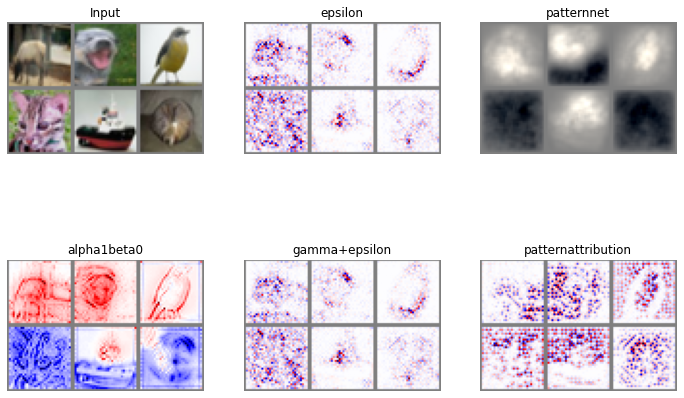

In [70]:
explanations = [
        # rule                  Pattern     plt_fn          Fig. pos
        ('alpha1beta0',         None,       heatmap_grid,   (1, 0)), 
        ('epsilon',             None,       heatmap_grid,   (0, 1)), 
        ('gamma+epsilon',       None,       heatmap_grid,   (1, 1)), 
        ('patternnet',          patterns,   signal_fn,      (0, 2)),
        ('patternattribution',  patterns,   heatmap_grid,   (1, 2)),
    ]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
print("Plotting")

# Plot inputs
input_to_plot = x.permute(0, 2, 3, 1).contiguous().detach().cpu().numpy()
input_to_plot = grid(input_to_plot, 3, 1.)
ax[0, 0].imshow(input_to_plot)
ax[0, 0].set_title("Input")
ax[0, 0].axis('off')

# Plot explanations
for i, (rule, pattern, fn, (p, q) ) in enumerate(explanations): 
    compute_and_plot_explanation(x, model_lrp, rule, ax[p, q], patterns=pattern, plt_fn=fn)

